<div>
<img src="images/icon_important.jpg" width="50" align="left"/>
</div>
<br>
<br>

#### __Important Legal Notice__
By running and editing this Jupyter notebook with the corresponding dataset, you agree that you will not use or store the data for other purposes than participating in the Champagne Coding with DNB & Women in Data Science, Oslo. You will delete the data and notebook after the event and will not attempt to identify any of the commentors.

### Anonymization

We've anonymized the data that was available from the start. Since there were names in some of the reviews, we decided to use the list of names from the scraped reviews and replace them with empty strings in the review text. Make sure that you always prioritize anonymization when working with potentially sensitive data :) 

In [1]:
flatten = lambda l: [item for sublist in l for item in sublist]

def remove_names(input_string, list_names):
    for n in list_names:
        input_string = input_string.replace(n.lower(), "")
        
    return input_string

def anonymization(df):
    """
    Create a list of names and search for them within the review text. 
    Replaces these names with blank strings.
    """
    # Store all of the names to a list
    all_names = df.Name.tolist()
    # Take the set of the list of names that are longer than 5
    names_list = list(set([n for n in all_names if len(n) > 5]))
    
    df.Review_Text = df.Review_Text.apply(lambda x: remove_names(str(x).lower(), names_list))
    
    return df

### Evaluating mobile app reviews

Here we will evaluate the mobile app reviews we scraped in the first notebook and:
- Analyse user sentiments using the comments and ratings
- Identify areas of interest among the reviews using topic modeling
- Explore and compare with other mobile app reviews

In [2]:
from pathlib import Path
current_directory = Path.cwd()
reviews_directory = Path(current_directory, 'reviews')

#### Let's start by reading in our reviews

In [3]:
import pandas as pd

In [4]:
df_dnb = pd.read_csv(Path(reviews_directory, 'dnb_reviews.csv'))

try:
    df_dnb = df_dnb.drop('Unnamed: 0', axis=1)
except:
    pass

df_dnb.head()

,Date,Review_Score,Review_Text
0,"August 21, 2019",4,"""sim tool launches before the page is done loa..."
1,"September 10, 2019",3,app is making my phone hang sevaral time ..als...
2,"August 16, 2019",3,i have been using the old and new version of t...
3,"August 21, 2019",4,worst app ever? slower and affords less privac...
4,"August 15, 2019",1,"har ikke root tilgang, kommer fortsatt ikke in..."


##### Read all the reviews in the directory and create a single dataframe

In [5]:
li = []
for f in Path(reviews_directory).glob("*.csv"):
    df = pd.read_csv(f)
    df['app_name'] = f.stem.replace('_reviews','')
    try:
        df.drop('Unnamed: 0', 
                axis = 1, 
                inplace=True)
    except:
        pass
    li.append(df)
    

df_all = pd.concat(li, 
                   axis=0)#, 
                   #ignore_index=True)

df_all.reset_index(inplace=True, drop=True)
try:
    df_all = anonymization(df_all)
except:
    pass
df_all.head()

/Users/alexandrag/anaconda3/envs/champagne_coding/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,Date,Language,Name,Review_Eng,Review_Score,Review_Text,app_name
0,"September 18, 2019",NaN,NaN,NaN,2,"it works but ""noe gikk galt"" error that follow...",sbanken
1,"September 15, 2019",NaN,NaN,NaN,1,this app is worse than ever. it was a downgrad...,sbanken
2,"September 6, 2019",NaN,NaN,NaN,1,crashes on startup. has been doing so for 2 mo...,sbanken
3,"September 13, 2019",NaN,NaN,NaN,3,"nice and clean app, works 90% of the time. but...",sbanken
4,"November 8, 2018",NaN,NaN,NaN,2,the app from ui experience perspective is simp...,sbanken


Double check and delete duplicate records

In [6]:
df_all.drop_duplicates(inplace=True)
df_dnb.drop_duplicates(inplace=True)

#### Understanding our reviews

In [7]:
%matplotlib inline
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

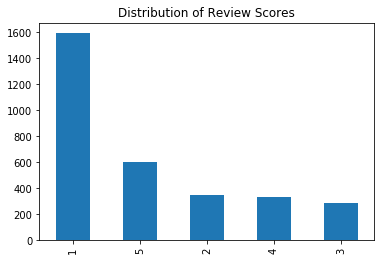

In [8]:
df_all.Review_Score.value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Review Scores")

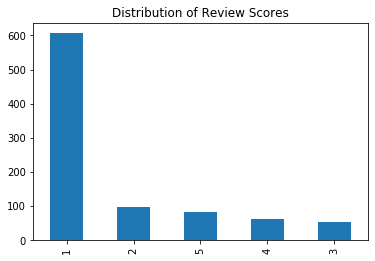

In [9]:
df_dnb.Review_Score.value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Review Scores")

Ok, let's try to understand the breakdown of these scores and see if we see any trends.

In [10]:
df_review_scores_over_time = df_dnb.groupby(['Date','Review_Score']).size().unstack()

df_review_scores_over_time.index = pd.to_datetime(df_review_scores_over_time.index)
df_review_scores_over_time.sort_index(inplace = True)

df_review_scores_over_time = df_review_scores_over_time.fillna(0)

Let's filter DNB's applications since prior to November 2018, the application was a web-based site for mobile use.

In [11]:
df_review_scores_over_time = df_review_scores_over_time[df_review_scores_over_time.index > 
                                                        pd.to_datetime('2018-11-01')]

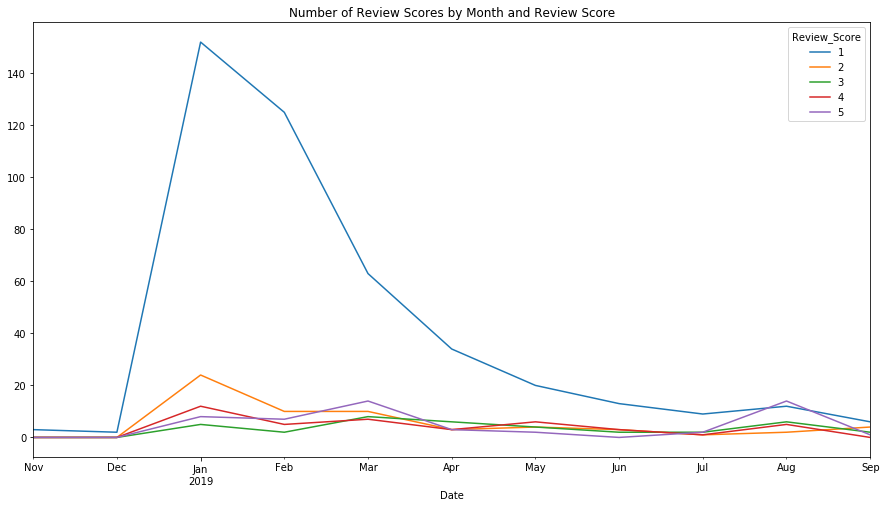

In [12]:
monthly = df_review_scores_over_time.groupby(pd.Grouper(freq="M")).sum()

monthly.plot(figsize=(15,8),
             title="Number of Review Scores by Month and Review Score")

## Topic Mining

### Word Counts

#### Top unigrams after removing english stop words

In [13]:
df_dnb['Review_Text'].dropna().shape

(901,)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    # First we use Count Vectorizer to create a matrix of the word counts
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    # Transform documents to document-term matrix
    bag_of_words = vec.transform(corpus)
    # Calculate how often each of the words occurs
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of the word to their counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list by frequency
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(df_dnb['Review_Text'].dropna(), 20)
for word, freq in common_words:
    print(word, freq)

df1 = pd.DataFrame(common_words, columns = ['Review_Text' , 'count'])

ikke 363
app 339
er 304
appen 280
og 269
jeg 262
på 259
det 253
den 238
en 191
inn 186
med 182
har 177
som 167
til 159
review 133
logge 133
dnb 128
men 124
av 105


In [15]:
df1.groupby('Review_Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 20 unigrams in review after removing stop words')

#### Top trigrams before removing stop words

In [16]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df_dnb['Review_Text'].dropna(), 20)

for word, freq in common_words:
    print(word, freq)
    
df3 = pd.DataFrame(common_words, columns = ['Review_Text' , 'count'])

to log in 31
logge inn med 24
den gamle appen 20
the old app 18
må logge inn 16
logge inn på 16
ikke logge inn 14
uten logge inn 13
for sjekke saldo 12
inn med bankid 12
bankid på mobil 11
inn med fingeravtrykk 10
den nye appen 10
får ikke logget 10
logge inn hver 9
måtte logge inn 9
norges største bank 9
saldo uten logge 9
det hele tatt 9
have to log 8


In [17]:
df3.groupby('Review_Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 20 trigrams in review before removing stop words')

#### Top trigrams after removing stop words

In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_dnb['Review_Text'].dropna(), 20)

for word, freq in common_words:
    print(word, freq)
    
df6 = pd.DataFrame(common_words, columns = ['Review_Text' , 'count'])

logge inn med 24
den gamle appen 20
må logge inn 16
logge inn på 16
ikke logge inn 15
uten logge inn 13
inn med bankid 12
bankid på mobil 11
inn med fingeravtrykk 10
den nye appen 10
får ikke logget 10
logge inn hver 9
måtte logge inn 9
norges største bank 9
saldo uten logge 9
det hele tatt 9
ikke logget inn 8
denne appen er 8
se saldo uten 8
den nye oppdateringen 8


In [19]:
df6.groupby('Review_Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    title='Top 20 trigrams in review after removing stop words')

#### Word Clouds

Let's get a feel for what are the major topics people mention using a visualization.

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud

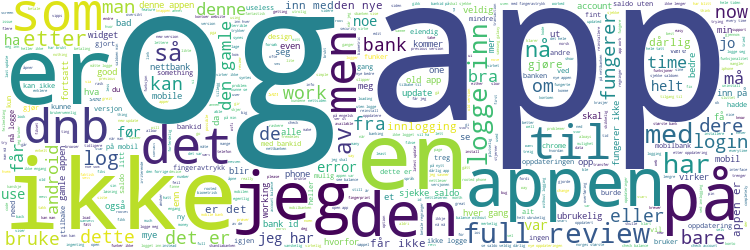

In [21]:
# Join the different processed titles together.
long_string = ",".join(str(i) for i in list(df_dnb.Review_Text.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

What do you observe in this word cloud? I see a lot of typical words that should probably be filtered out before we mine for topics. 

In text analysis, we call these words ```stopwords```. We are fortunate to have libraries like nltk that have done a lot of the heavy lifting here for us, but we may have to add some more words to our list to get rid of words that aren't adding value to this analysis.

Let's start by exploring our out-of-the box options with ```nltk``` stopwords:

```
from nltk.corpus import stopwords
stopwords.words() # here you can also specify specific languages :) i.e. .words('english')
```
    
Should we include _all_ of the stopwords or just some _specific languages_? 

__TODO__: Check which languages are available. 

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandrag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
stopwords.words()[-20:]

['mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

How would you create your own set of stop words depending on the task?

In [24]:
our_stopwords = []
our_stopwords.append('app')
our_stopwords.append('appen')
our_stopwords.append('Full')
our_stopwords.append('Review')

Let's see how it changes our wordcloud if we add some of the un-interesting words to our list.

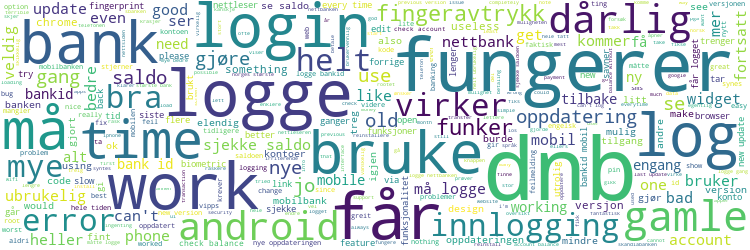

In [25]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      stopwords=stopwords.words('norwegian')+ stopwords.words('english')+ our_stopwords,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

__TODO:__ Create a word cloud for a couple of the applications

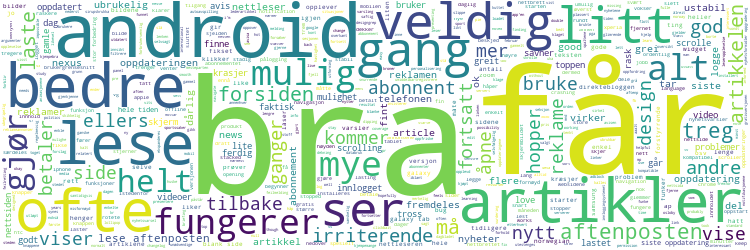

In [26]:
# Join the different processed titles together.
long_string_app = ",".join(str(i) for i in list(df_all[df_all.app_name=='aftenposten'].Review_Text.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      width=750,
                      height=250,
                      max_words=5000,
                      stopwords=stopwords.words('norwegian')+ stopwords.words('english')+ our_stopwords,
                      contour_width=3, 
                      contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string_app)

# Visualize the word cloud
wordcloud.to_image()

In [27]:
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

### Pre-processing

Now that we have a feel for our data, let's prepare it for modeling.

In [28]:
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('wordnet')

#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexandrag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandrag/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
def to_lowercase(words):
    """
    Convert all characters to lowercase from list of tokenized words
    """
    
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """
    Remove punctuation from list of tokenized words
    """
    
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def remove_stopwords(words):
    """
    Remove stop words from list of tokenized words
    """
    
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """
    Stem words in list of tokenized words
    """
    
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """
    Lemmatize verbs in list of tokenized words
    """
    
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas



def pre_process(review_text):
    """
    A function that puts together our individual processes
    to pre-process our reviews.
    """
    
    # tokenize
    tokens = word_tokenize(review_text) 
    # lower case
    tokens = to_lowercase(tokens) 
    # remove punctuation
    tokens = remove_punctuation(tokens)
    
    # lemmatize / stem?
    tokens = lemmatize_verbs(tokens)
    
    # join all of the tokens
    tokens_sentence = ' '.join(tokens)
    
    return tokens_sentence

In [30]:
df_dnb.dropna(subset=['Review_Text'], inplace = True)
df_dnb['normalized_text'] = df_dnb.Review_Text.apply(lambda x: pre_process(x))

df_dnb.normalized_text.head()

0    sim tool launch before the page be do load blo...
1    app be make my phone hang sevaral time also fo...
2    i have be use the old and new version of the s...
3    worst app ever slower and afford less privacy ...
4    har ikke root tilgang kommer fortsatt ikke inn...
Name: normalized_text, dtype: object

## Count Vectorizer
### Let's convert our documents to a matrix of terms and their counts

Here we will use the ```CountVectorizer```. This will convert our documents to a matrix of token counts. __Note:__  if you do not specify any feature selection then the number of features will be equal to the vocabulary size found by analyzing the data. That might take a while to process (and a lot of memory!) if you have a large set of data.

<div>
<img src="images/word_to_vectors.png" width="500" align="center"/>
</div>
<br>
<br>

Source: https://towardsdatascience.com/word-to-vectors-natural-language-processing-b253dd0b0817

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
count = CountVectorizer(stop_words=stopwords.words('norwegian')+
                        stopwords.words('english')+
                        our_stopwords)
count.fit(df_dnb.normalized_text)

count_matrix = count.fit_transform(df_dnb.normalized_text)

/Users/alexandrag/anaconda3/envs/champagne_coding/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['full', 'review'] not in stop_words.



In [33]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, 
                 vectorizer, 
                 n_top_words):
    
    words = vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

### Latent Dirichlet Allocation (LDA)

We'll start by testing Latent Dirichlet Allocation to find the topics.

In [34]:
# Tweak the two parameters below
number_topics = 5
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_matrix)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, 
             count, 
             number_words)

Topics found via LDA:

Topic #0:
work logge bank log time

Topic #1:
logge dnb review full får

Topic #2:
nt review log full logge

Topic #3:
fungerer bank review full logge

Topic #4:
full work review dnb update


## TF-IDF Vectorizer
### Let's try a different vectorizer

Here we will use the TF-IDF vectorizer. TF-IDF stands for __term frequency - inverse document frequency__. This vectorizer will use the ```CountVectorizer``` class as we did in the previous step, but includes a transformation to calculate an appropriate weighting for our terms.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

<div>
<img src="images/tfidf.png" width="500" align="center"/>
</div>
<br>
<br>

Source: http://mropengate.blogspot.com/2016/04/tf-idf-in-r-language.html

This will create a matrix that looks like this

<div>
<img src="images/tfidf_vec.png" width="500" align="center"/>
</div>
<br>
<br>

Sourrce: https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('norwegian')+
                        stopwords.words('english')+
                        our_stopwords)
tfidf.fit(df_dnb.normalized_text)

/Users/alexandrag/anaconda3/envs/champagne_coding/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['full', 'review'] not in stop_words.



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den',
                            'til', 'er', 'som', 'på', 'de', 'med', 'han', 'av',
                            'ikke', 'ikkje', 'der', 'så', 'var', 'meg', 'seg',
                            'men', 'ett', 'har', 'om', 'vi', 'min', 'mitt', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [37]:
tfidf_matrix = tfidf.fit_transform(df_dnb.normalized_text)

In [38]:
# Tweak the two parameters below
number_topics = 5
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(tfidf_matrix)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, 
             tfidf, 
             number_words)

Topics found via LDA:

Topic #0:
work fungerer version ok root

Topic #1:
saldo funker dårlig bank tilbake

Topic #2:
virker oppdatering logge får bedre

Topic #3:
logge veldig kommer excellent fint

Topic #4:
nt log update good ca


#### TODO: How might you improve the topics?

Starting points:
- More stopwords?
- Stricter vectorization rules?
- Translating?

#### TODO: How do topics vary by application and review score?

Starting points:
- Among those who are most positive, what do they mention?
- Among those who are most negative, what do they mention?

### Let's review the topics after translating and use a different method for finding topics.

In [39]:
from sklearn.decomposition import TruncatedSVD

We've translated the file and saved it in the reviews folder. Let's start by reading it in.

In [40]:
df_dnb_translated = pd.read_csv(Path(reviews_directory, 'dnb_reviews-translated.csv'))

In [41]:
reindexed_data = df_dnb_translated['Review_Eng'].apply(lambda x: pre_process(x))

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('norwegian')+
                                   stopwords.words('english')+ 
                                   [w.lower() for w in our_stopwords], 
                                   use_idf=True, 
                                   smooth_idf=True)

reindexed_data = reindexed_data.values

document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

### Latent Semantic Analysis (LSA)

In [42]:
n_topics = 6

lsa_model = TruncatedSVD(n_components = n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [43]:
print("Our TF-IDF matrix shape: {}".format(document_term_matrix.shape))
print("Our LSA matrix shape: {}".format(lsa_topic_matrix.shape))

explained_variance = lsa_model.explained_variance_ratio_.sum()
print("Sum of explained variance ratio: {}%".format(int(explained_variance * 100)))

Our TF-IDF matrix shape: (897, 2047)
Our LSA matrix shape: (897, 6)
Sum of explained variance ratio: 7%


In [44]:
from collections import Counter
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [45]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [46]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  work bank log
Topic 2:  work fine 60
Topic 3:  bad update new
Topic 4:  good use sign
Topic 5:  nt useless ca
Topic 6:  balance better see


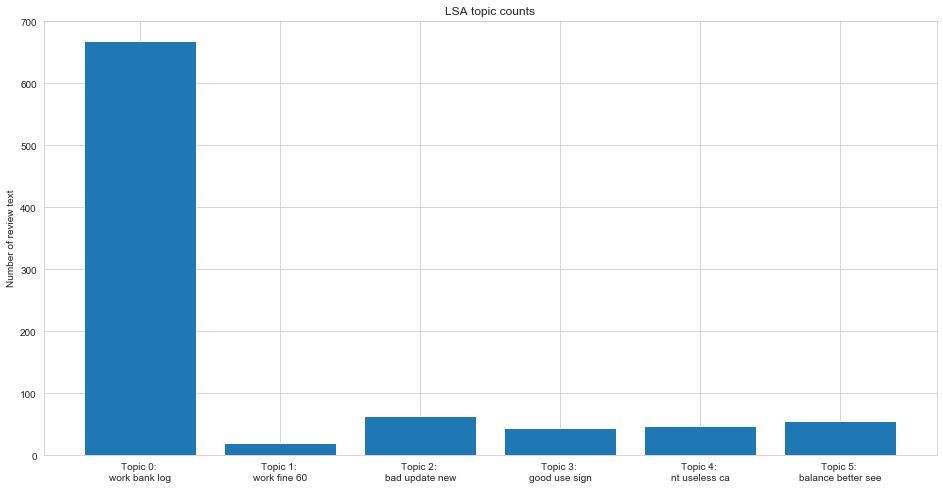

In [47]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

In [48]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, 
                      perplexity=50, 
                      learning_rate=100, 
                      n_iter=2000, 
                      verbose=1, 
                      random_state=0, 
                      angle=0.75)

tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 897 samples in 0.001s...
[t-SNE] Computed neighbors for 897 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 897 / 897
[t-SNE] Mean sigma: 0.043974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.917019
[t-SNE] KL divergence after 2000 iterations: 0.611368


In [49]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [50]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [51]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label

top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)